In [181]:
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from tqdm.auto import tqdm

from sklearn import metrics as m

In [182]:
mod_map = {
    'median-3x3': r'$3\times3$ Median Filtering',
    'median-5x5': r'$5\times5$ Median Filtering',
    'median-7x7': r'$7\times7$ Median Filtering',
    'mean-3x3': r'$3\times3$ Mean Filtering',
    'mean-5x5': r'$5\times5$ Mean Filtering',
    'mean-7x7': r'$7\times7$ Mean Filtering',
    'hist-eq': 'Histogram Equalization',
    'jpeg-60': 'JPEG Compression (q=60)'
}

In [183]:
def collect_data(run_id):
    adv_dir = Path('runs') / run_id / 'advs'
    advs = adv_dir.glob('*.csv')
    data = [pd.read_csv(a, index_col=0) for a in advs]
    data = pd.concat(data, ignore_index=True)
    data['modification'] = run_id
    return data

runs = [
    'median-7x7',
    'median-5x5',
    'median-3x3',
    'mean-7x7',
    'mean-5x5',
    'mean-3x3',
    'hist-eq',
    'jpeg-60'
]

data = [collect_data(r) for r in runs]
data = pd.concat(data, ignore_index=True)
data = data[data.sample_idx < 800]
data

,sample_idx,label,tol,eps,score,modification
247,294,0,1.000000e-09,0.0000,3.285926e-05,median-7x7
248,294,0,1.000000e-09,0.0001,3.294005e-05,median-7x7
249,294,0,1.000000e-09,0.0003,3.310251e-05,median-7x7
250,294,0,1.000000e-09,0.0005,3.326590e-05,median-7x7
251,294,0,1.000000e-09,0.0010,3.367956e-05,median-7x7
...,...,...,...,...,...,...
2526064,188,0,1.000000e+03,3.0000,1.293078e-10,jpeg-60
2526065,188,0,1.000000e+03,5.0000,1.293078e-10,jpeg-60
2526066,188,0,1.000000e+03,10.0000,1.293078e-10,jpeg-60
2526067,188,0,1.000000e+03,30.0000,1.293078e-10,jpeg-60


In [184]:
data.groupby('modification').sample_idx.nunique()

modification
hist-eq       800
jpeg-60       705
mean-3x3      800
mean-5x5      800
mean-7x7      800
median-3x3    800
median-5x5    800
median-7x7    800
Name: sample_idx, dtype: int64

# Robust Accuracy / AuROC

In [185]:
def compute_metrics(x):
    return pd.Series({
        'auc': m.roc_auc_score(x.label, x.score),
        'accuracy': m.accuracy_score(x.label, x.score >= 0.5),
    })
        
metrics = data.groupby(['modification', 'tol', 'eps']).apply(compute_metrics).reset_index()
metrics = metrics[(metrics.eps == 0) | ((metrics.eps >= 0.01) & (metrics.eps <= 50.0))]  # keep interesting epsilons only
table = pd.pivot_table(metrics, index=['modification', 'eps'], columns='tol', values=['auc', 'accuracy'])
table = table.applymap(lambda x: f'{x:.1%}')
table

accuracy                                         \
tol                1.000000e-09 1.000000e-08 1.000000e-07 1.000000e-06   
modification eps                                                         
hist-eq      0.00         98.2%        98.2%        98.2%        98.2%   
             0.01         98.2%        98.2%        98.2%        98.2%   
             0.03         98.2%        98.2%        98.2%        98.2%   
             0.05         98.2%        98.2%        98.2%        98.2%   
             0.10         98.2%        98.2%        98.2%        98.2%   
...                         ...          ...          ...          ...   
median-7x7   3.00         66.2%        66.4%        66.2%        66.4%   
             5.00         66.0%        66.1%        66.0%        66.1%   
             10.00        66.0%        66.1%        66.0%        66.1%   
             30.00        66.0%        66.1%        66.0%        66.1%   
             50.00        66.0%        66.1%        66.0%        66.1%   

                                                                        \
tol                1.000000e-05 1.000000e-04 1.000000e-03 1.000000e-02   
modification eps                                                         
hist-eq      0.00         98.2%        98.2%        98.4%        98.2%   
             0.01         98.2%        98.2%        98.4%        98.1%   
             0.03         98.2%        98.2%        98.4%        98.1%   
             0.05         98.2%        98.2%        98.2%        98.1%   
             0.10         98.2%        98.2%        98.2%        98.1%   
...                         ...          ...          ...          ...   
median-7x7   3.00         65.9%        62.6%        18.8%        49.8%   
             5.00         65.6%        62.4%        17.4%        49.6%   
             10.00        65.6%        62.4%        17.1%        49.6%   
             30.00        65.6%        62.4%        17.1%        49.6%   
             50.00        65.6%        62.4%        17.1%        49.6%   

                                              ...          auc               \
tol                1.000000e-01 1.000000e+00  ... 1.000000e-06 1.000000e-05   
modification eps                              ...                             
hist-eq      0.00         98.2%        97.8%  ...        99.6%        99.6%   
             0.01         98.2%        97.8%  ...        99.6%        99.6%   
             0.03         98.2%        97.8%  ...        99.6%        99.6%   
             0.05         98.2%        97.8%  ...        99.6%        99.6%   
             0.10         98.1%        97.4%  ...        99.5%        99.5%   
...                         ...          ...  ...          ...          ...   
median-7x7   3.00         67.1%        62.9%  ...        70.2%        69.9%   
             5.00         66.9%        61.9%  ...        69.7%        69.5%   
             10.00        66.9%        61.9%  ...        69.7%        69.4%   
             30.00        66.9%        61.9%  ...        69.7%        69.4%   
             50.00        66.9%        61.9%  ...        69.7%        69.4%   

                                                                        \
tol                1.000000e-04 1.000000e-03 1.000000e-02 1.000000e-01   
modification eps                                                         
hist-eq      0.00         99.6%        99.6%        99.6%        99.6%   
             0.01         99.6%        99.6%        99.6%        99.6%   
             0.03         99.6%        99.6%        99.6%        99.6%   
             0.05         99.6%        99.5%        99.6%        99.6%   
             0.10         99.5%        99.5%        99.6%        99.6%   
...                         ...          ...          ...          ...   
median-7x7   3.00         66.8%        10.9%        65.2%        91.1%   
             5.00         66.3%         8.1%        64.8%        90.5%   
             10.00        66

In [196]:
textab = table.auc
textab = textab.iloc[:, 3:]
textab = textab.loc[[
    ('mean-7x7', 0.0),
    ('mean-7x7', 1.0),
    ('mean-7x7', 3.0),
    ('mean-7x7', 5.0),
    ('mean-7x7', 10.0),
    
    ('median-5x5', 0.0),
    ('median-5x5', 0.5),
    ('median-5x5', 1.0),
    ('median-5x5', 3.0),
    ('median-5x5', 5.0),
    
    ('median-7x7', 0.0),
    ('median-7x7', 0.5),
    ('median-7x7', 1.0),
    ('median-7x7', 3.0),
    ('median-7x7', 5.0),
]]
textab = textab.rename(columns=lambda x: rf'$10^{{{np.log10(x):.0f}}}$', level=0)
textab.columns = textab.columns.rename(r'$\tau_\text{test}$')
textab.index = textab.index.rename(['Modification', r'$\varepsilon$'])
textab.index = textab.index.set_levels(textab.index.levels[0].map(mod_map), level=0)
textab.index = textab.index.set_levels(textab.index.levels[1].map(lambda x: '-' if x == 0 else x), level=1)
textab = textab.applymap(lambda x: x.replace('%', r'').replace('100.0', '100'))
textab = textab.applymap(lambda x: rf'\co{{{x}}}')
print(textab.to_latex(escape=False, column_format=r'lc*X{13}', multirow=True))

\begin{tabular}{lc*X{13}}
\toprule
                            & $\tau_\text{test}$ &  $10^{-6}$ &  $10^{-5}$ &  $10^{-4}$ &  $10^{-3}$ &  $10^{-2}$ &  $10^{-1}$ &   $10^{0}$ &   $10^{1}$ &   $10^{2}$ &   $10^{3}$ \\
Modification & $\varepsilon$ &            &            &            &            &            &            &            &            &            &            \\
\midrule
\multirow{5}{*}{$7\times7$ Mean Filtering} & - &   \co{100} &   \co{100} &   \co{100} &   \co{100} &   \co{100} &   \co{100} &   \co{100} &   \co{100} &   \co{100} &   \co{100} \\
                            & 1.0 &  \co{98.4} &  \co{98.4} &  \co{98.2} &  \co{94.0} &  \co{94.1} &  \co{98.6} &  \co{99.4} &  \co{96.7} &  \co{96.2} &  \co{96.5} \\
                            & 3.0 &  \co{88.9} &  \co{88.8} &  \co{86.6} &  \co{49.4} &  \co{45.7} &  \co{93.1} &  \co{96.7} &  \co{76.6} &  \co{60.2} &  \co{61.6} \\
                            & 5.0 &  \co{81.9} &  \co{81.9} &  \co{77.8} &  \co{12.8} &  \co{10.9}

In [ ]:
Path('figures/').mkdir(exist_ok=True)

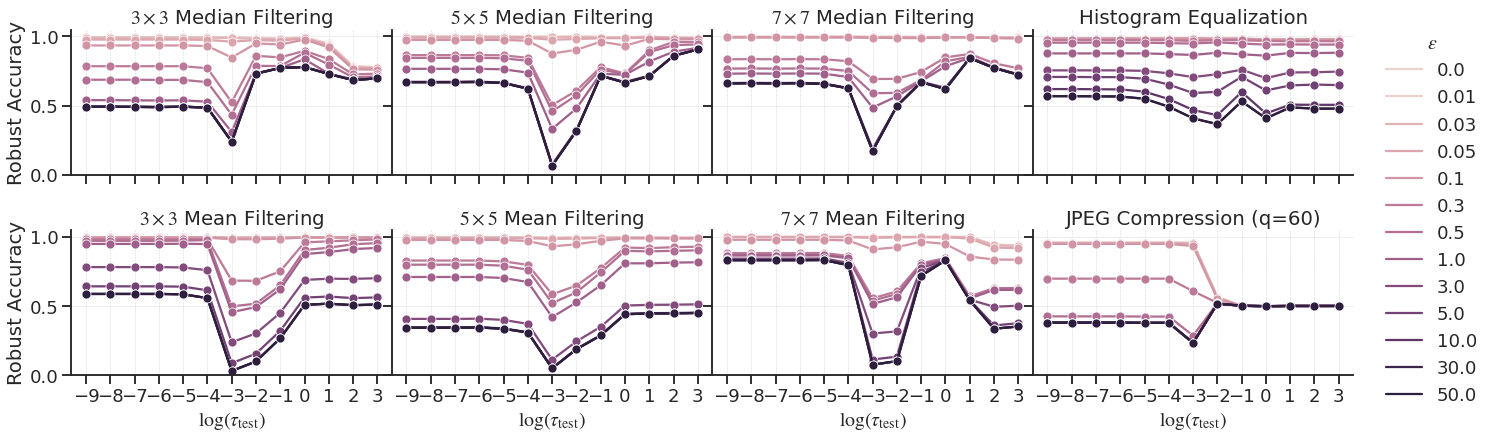

In [187]:
from matplotlib.colors import LogNorm

sns.set(context='talk', style='ticks', rc={'mathtext.fontset' : 'stix'}, font_scale=1.1)

logtol = np.log10(metrics.tol)
plot_data = metrics.assign(logtol=logtol)
plot_data['modification'] = plot_data['modification'].map(mod_map)
# plot_data.loc[plot_data.eps == 0.0, 'eps'] = 'Original'
plot_data = plot_data.rename(columns={'eps': r'$\varepsilon$'})

col_order = [mod_map[k] for k in (
    'median-3x3',
    'median-5x5',
    'median-7x7',
    'hist-eq',
    'mean-3x3',
    'mean-5x5',
    'mean-7x7',
    'jpeg-60'
)]

g = sns.relplot(kind='line', data=plot_data, col='modification', col_wrap=4, col_order=col_order,
                x='logtol', y='accuracy', hue=r'$\varepsilon$', hue_norm=LogNorm(clip=True),
                aspect=1.5, height=3.25,
                marker='o', legend='full', facet_kws=dict(margin_titles=True, despine=False, sharex=True))

g.set(xticks=np.unique(logtol))
g.set(xlabel=r'$\log(\tau_\mathrm{test})$')
g.set(ylabel='Robust Accuracy')
g.set(ylim=(0, None))
g.set_titles(col_template='{col_name}')
g.tight_layout()

for ax in g.axes.flatten():
    ax.grid(visible=True, which='both', color='lightgray', linewidth=0.5, linestyle='--')

plt.subplots_adjust(wspace=0)
sns.despine()
g.savefig('figures/robacc-vs-testtol.pdf')

In [ ]:
sns.set_theme(context='notebook', style='ticks')

def plot_roc(labels, scores, color=None, label=None):
    ax = plt.gca()
    m.RocCurveDisplay.from_predictions(labels, scores, color=color, label=label, ax=ax)
    ax.plot((0, 1), (0, 1), color='gray', ls=(0,(5,10)), lw=0.3)
    ax.grid()

plot_data = data[(data.eps == 0) | ((data.eps >= 0.1) & (data.eps <= 50.0))]
grid = sns.FacetGrid(data=plot_data, col='eps', row='modification', hue='tol', palette='icefire', aspect=.9, sharex=False, margin_titles=True)
grid.map(plot_roc, 'label', 'score')
grid.set(xlabel='FPR', ylabel='TPR')
grid.add_legend()

grid.facet_axis(0, 0).title.set(text='pristine')
for i in range(4):
    for j in range(len(runs)):
        grid.facet_axis(j, i).set_xscale('log')
        grid.facet_axis(j, i).set_xlim(None, 1)

grid.tight_layout()

# Show Adversarial Samples vs $\varepsilon$

In [6]:
from matplotlib.offsetbox import AnchoredText
import numpy as np
import torch

def torch_to_numpy(x):
    return x.squeeze().permute((1, 2, 0)).numpy()

def show_adv_vs_epsilon(run_dir, sample_no):
    run_dir = Path(run_dir)
    original_advs = torch.load(run_dir / 'advs' / f'{2 * sample_no}.pth', map_location='cpu')
    modified_advs = torch.load(run_dir / 'advs' / f'{2 * sample_no + 1}.pth', map_location='cpu')

    original_advs = [a for a in original_advs if (a['eps'] == 0) or (a['eps'] >= 0.1)]
    modified_advs = [a for a in modified_advs if (a['eps'] == 0) or (a['eps'] >= 0.1)]

    original_first_success_idx = min(i for i, a in enumerate(original_advs) if a['success'])
    modified_first_success_idx = min(i for i, a in enumerate(modified_advs) if a['success'])

    original_unperturbed = torch_to_numpy(original_advs[0]['clipped_adv'])
    modified_unperturbed = torch_to_numpy(modified_advs[0]['clipped_adv'])

    n_eps = len(original_advs)

    fig, axes = plt.subplots(nrows=4, ncols=n_eps, figsize=(20, 8.5))
    for i in range(n_eps):
        original_adv = torch_to_numpy(original_advs[i]['clipped_adv'])
        modified_adv = torch_to_numpy(modified_advs[i]['clipped_adv'])

        original_perturbation = original_adv - original_unperturbed
        original_perturb_norm = np.linalg.norm(original_perturbation.flatten())
        original_perturbation = original_perturbation.mean(axis=2)  # mean over channels
        original_perturbation = matplotlib.cm.viridis(original_perturbation * 10)  # magnify

        modified_perturbation = modified_adv - modified_unperturbed
        modified_perturb_norm = np.linalg.norm(modified_perturbation.flatten())
        modified_perturbation = modified_perturbation.mean(axis=2)
        modified_perturbation = matplotlib.cm.viridis(modified_perturbation * 10)

        axes[0, i].imshow(original_adv)
        axes[1, i].imshow(original_perturbation)
        axes[2, i].imshow(modified_adv)
        axes[3, i].imshow(modified_perturbation)

        eps = original_advs[i]['eps']
        axes[0, i].set_title(f'$ɛ = {eps:g}$')
        
        if i == original_first_success_idx:
            at = AnchoredText(f'$𝛿 = {original_perturb_norm:g}$', frameon=True, loc='lower center')
            axes[0, i].add_artist(at)
        if i == modified_first_success_idx:
            at = AnchoredText(f'$𝛿 = {modified_perturb_norm:g}$', frameon=True, loc='lower center')
            axes[2, i].add_artist(at)

        color = 'green' if original_advs[i]['success'] else 'red'
        plt.setp(axes[0, i].spines.values(), color=color)

        color = 'green' if modified_advs[i]['success'] else 'red'
        plt.setp(axes[2, i].spines.values(), color=color)

        for j in range(4):
            axes[j, i].tick_params(which='both', size=0, labelsize=0)

    plt.subplots_adjust(wspace=0, hspace=0)
    
    return fig, axes

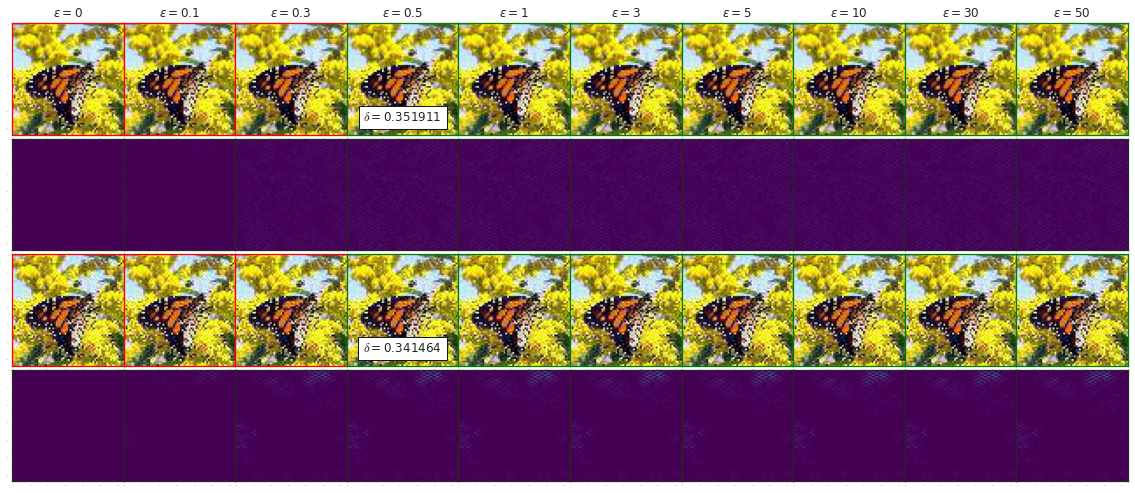

In [7]:
run_dir = 'runs/jpeg-60'
sample_no = 2

_ = show_adv_vs_epsilon(run_dir, sample_no)

# Show Pristine and Adversarial Samples vs Modification

In [161]:
from matplotlib.offsetbox import AnchoredText
import matplotlib.patheffects as PathEffects

def torch_to_numpy(x):
    return x.squeeze().permute((1, 2, 0)).numpy()


def get_sample(sample_no, mod, pristine=True):
    no = 2 * sample_no + (0 if pristine else 1)

    advs_path = Path('runs') / mod / 'advs' / f'{no}.pth'
    advs = torch.load(advs_path, map_location='cpu')

    # non-attacked
    image = torch_to_numpy(advs[0]['clipped_adv'])

    # attacked
    min_eps_idx = min(i for i, a in enumerate(advs) if a['success'])
    adv_image = torch_to_numpy(advs[min_eps_idx]['clipped_adv'])

    # perturbation (color-mapped)
    adv_perturb = adv_image - image
    adv_perturb_norm = np.linalg.norm(adv_perturb.flatten())
    if False:
        adv_perturb = adv_perturb.mean(axis=2)  # mean over channels
        adv_perturb = matplotlib.cm.viridis(adv_perturb * 10)  # magnify
    else:
        adv_perturb *= 10 if adv_perturb_norm < 1 else 1
        adv_perturb = np.clip(adv_perturb + 0.5, 0, 1)

    return image, adv_image, adv_perturb, adv_perturb_norm


def show_modifications(sample_no):
    runs = Path('runs')

    modifications = runs.glob('*')
    modifications = filter(lambda p: (p / 'advs').exists(), modifications)
    modifications = map(lambda p: p.name, modifications)
    modifications = set(modifications)
    modifications = [m for m in mod_map.keys() if m in modifications]
    n_mod = len(modifications)

    sns.set(context='paper', style='ticks')

    fig, axes = plt.subplots(5, n_mod + 1, figsize=(16, 9.075))
    #fig, axes = plt.subplots(n_mod, 3, figsize=(7.5, 20*9/8))

    at_common = dict(
        frameon=False,
        loc='lower right',
        borderpad=0.1,
        prop=dict(
            color='white',
            path_effects=[PathEffects.withStroke(linewidth=3, foreground='k')]
        )
    )
    
    plot_mod_map = {
        'median-3x3': '$3\\times3$ Median\nFiltering',
        'median-5x5': '$5\\times5$ Median\nFiltering',
        'median-7x7': '$7\\times7$ Median\nFiltering',
        'mean-3x3': '$3\\times3$ Mean\nFiltering',
        'mean-5x5': '$5\\times5$ Mean\nFiltering',
        'mean-7x7': '$7\\times7$ Mean\nFiltering',
        'hist-eq': 'Histogram\nEqualization',
        'jpeg-60': 'JPEG (q=60)\nCompression'
    }

    for i, mod in enumerate(modifications, start=1):
        image, adv_image, adv_perturb, adv_perturb_norm = get_sample(sample_no, mod, pristine=False)
        axes[0, i].set_title(plot_mod_map[mod])
        axes[0, i].imshow(image)
        axes[1, i].imshow(adv_image)
        axes[2, i].imshow(adv_perturb)
        # tmp_ax = axes[i, 2].twinx()
        # tmp_ax.set_ylabel(f'$𝛿 = {adv_perturb_norm:.3g}$')

        at = AnchoredText(f'$𝛿 = {adv_perturb_norm:.2g}$', **at_common)
        axes[1, i].add_artist(at)

        image, adv_image, adv_perturb, adv_perturb_norm = get_sample(sample_no, mod, pristine=True)
        # axes[0, i].imshow(image)
        axes[3, i].imshow(adv_image)
        axes[4, i].imshow(adv_perturb)

        at = AnchoredText(f'$𝛿 = {adv_perturb_norm:.2g}$', **at_common)
        axes[3, i].add_artist(at)

        for j in range(5):
            axes[j, i].tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
        # tmp_ax.tick_params(which='both', size=0, labelsize=0, color='white')

    axes[0, 0].imshow(image)
    axes[0, 0].tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)

    for i in range(1, 5):
        fig.delaxes(axes[i, 0])

    axes[0, 0].set_title('Origianl')
    axes[1, 1].set_ylabel('Adv. Sample\n(TAMP ➝ ORIG)')
    axes[2, 1].set_ylabel('Perturbation\n(TAMP ➝ ORIG)')
    axes[3, 1].set_ylabel('Adv. Sample\n(ORIG ➝ TAMP)')
    axes[4, 1].set_ylabel('Perturbation\n(ORIG ➝ TAMP)')
    
    plt.subplots_adjust(wspace=0, hspace=0)
    
    return fig, axes


def show_compact_modifications(sample_no):
    runs = Path('runs')

    modifications = runs.glob('*')
    modifications = filter(lambda p: (p / 'advs').exists(), modifications)
    modifications = map(lambda p: p.name, modifications)
    modifications = set(modifications)
    modifications = [m for m in mod_map.keys() if m in modifications]
    n_mod = len(modifications)

    sns.set(context='paper', style='ticks')

    fig, axes = plt.subplots(3, n_mod + 1, figsize=(16, 9.075*3/5))
    #fig, axes = plt.subplots(n_mod, 3, figsize=(7.5, 20*9/8))

    at_common = dict(
        frameon=False,
        loc='lower right',
        borderpad=0.1,
        prop=dict(
            color='white',
            path_effects=[PathEffects.withStroke(linewidth=3, foreground='k')]
        )
    )
    
    plot_mod_map = {
        'median-3x3': '$3\\times3$ Median\nFiltering',
        'median-5x5': '$5\\times5$ Median\nFiltering',
        'median-7x7': '$7\\times7$ Median\nFiltering',
        'mean-3x3': '$3\\times3$ Mean\nFiltering',
        'mean-5x5': '$5\\times5$ Mean\nFiltering',
        'mean-7x7': '$7\\times7$ Mean\nFiltering',
        'hist-eq': 'Histogram\nEqualization',
        'jpeg-60': 'JPEG (q=60)\nCompression'
    }

    for i, mod in enumerate(modifications, start=1):
        image, adv_image, adv_perturb, adv_perturb_norm = get_sample(sample_no, mod, pristine=False)
        axes[0, i].set_title(plot_mod_map[mod])
        axes[0, i].imshow(image)
        #axes[1, i].imshow(adv_image)
        axes[1, i].imshow(adv_perturb)
        # tmp_ax = axes[i, 2].twinx()
        # tmp_ax.set_ylabel(f'$𝛿 = {adv_perturb_norm:.3g}$')

        at = AnchoredText(f'$𝛿 = {adv_perturb_norm:.2g}$', **at_common)
        axes[1, i].add_artist(at)

        image, adv_image, adv_perturb, adv_perturb_norm = get_sample(sample_no, mod, pristine=True)
        # axes[0, i].imshow(image)
        #axes[3, i].imshow(adv_image)
        axes[2, i].imshow(adv_perturb)

        at = AnchoredText(f'$𝛿 = {adv_perturb_norm:.2g}$', **at_common)
        axes[2, i].add_artist(at)

        for j in range(3):
            axes[j, i].tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
        # tmp_ax.tick_params(which='both', size=0, labelsize=0, color='white')

    axes[0, 0].imshow(image)
    axes[0, 0].tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)

    for i in range(1, 3):
        fig.delaxes(axes[i, 0])

    axes[0, 0].set_title('Origianl')
    #axes[1, 1].set_ylabel('Adv. Sample\n(TAMP ➝ ORIG)')
    axes[1, 1].set_ylabel('Adversarial\nPerturbation\n(TAMP ➝ ORIG)')
    #axes[3, 1].set_ylabel('Adv. Sample\n(ORIG ➝ TAMP)')
    axes[2, 1].set_ylabel('Adversarial\nPerturbation\n(ORIG ➝ TAMP)')
    
    plt.subplots_adjust(wspace=0, hspace=0)
    
    return fig, axes

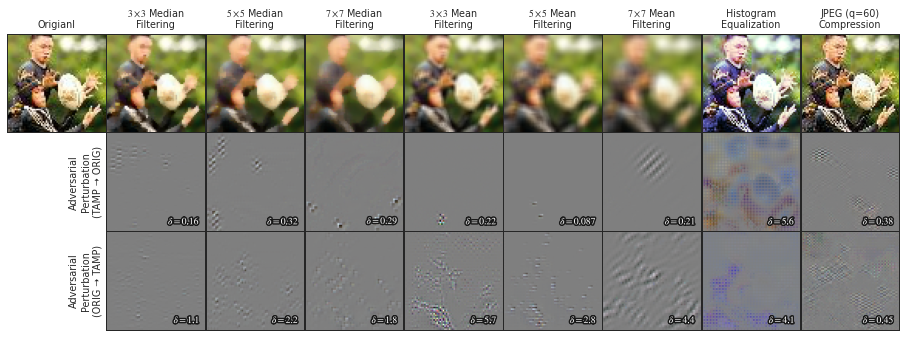

In [162]:
fig, axes = show_compact_modifications(22)
fig.savefig('figures/compact_samples.pdf', bbox_inches='tight')

# Adversarial Sample Statistics

In [188]:
# adv_paths = [run_dir / 'advs' / f'{i}.pth' for i in range(2000)]
# adv_paths = [a for a in adv_paths if a.exists()]
adv_paths = Path('.').glob('runs/*/advs/*.pth')
adv_paths = filter(lambda x: int(x.stem) < 800, adv_paths)
adv_paths = list(adv_paths)

def get_perturbation_norm(adv_path):
    advs = torch.load(adv_path, map_location='cpu')

    unperturbed = advs[0]['clipped_adv']

    first_success = min(i for i, a in enumerate(advs) if a['success'])
    adversarial = advs[first_success]['clipped_adv']

    perturbation = adversarial - unperturbed
    perturb_norm = np.linalg.norm(perturbation.flatten().numpy())

    return perturb_norm

perturb_norms = [get_perturbation_norm(a) for a in tqdm(adv_paths)]
eps_bins = [a['eps'] for a in torch.load(adv_paths[0], map_location='cpu')]

  0%|          | 0/6305 [00:00<?, ?it/s]

In [189]:
mod = [a.parent.parent.name for a in adv_paths]
is_pristine = [int(a.stem) % 2 == 0 for a in adv_paths]
pn = pd.DataFrame({
    'modification': mod,
    'perturb_norm': perturb_norms,
    'Initial Class': is_pristine
})

pn = pn[pn.perturb_norm != 0]
pn['modification'] = pn['modification'].map(mod_map)
pn['Initial Class'] = pn['Initial Class'].map({True: r'ORIG $\to$ TAMP', False: r'TAMP $\to$ ORIG'})

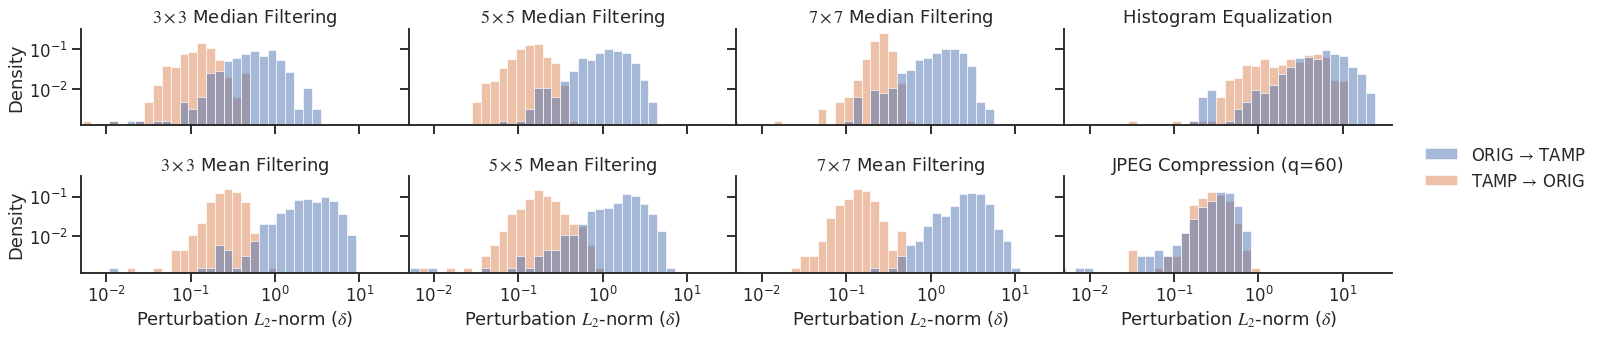

In [190]:
sns.set(context='talk', style='ticks', rc={'mathtext.fontset' : 'stix'}, font_scale=1)

# fig = plt.figure(figsize=(5, 4))
col_order = [mod_map[k] for k in (
    'median-3x3',
    'median-5x5',
    'median-7x7',
    'hist-eq',
    'mean-3x3',
    'mean-5x5',
    'mean-7x7',
    'jpeg-60'
)]

g = sns.displot(data=pn, col='modification', col_wrap=4, col_order=col_order,
                x='perturb_norm', hue='Initial Class', stat='density',
                log_scale=[True,True], aspect=2, height=2.5, facet_kws=dict(legend_out=True))
g.set_titles(col_template='{col_name}')
g.set(xlim=(0.005, None))
g.set(xlabel=r'Perturbation $L_2$-norm ($\delta$)')

for ax in g.axes.flat:
    ax.minorticks_off()

plt.subplots_adjust(wspace=0)

g.legend.set_title('')
g.savefig('figures/perturb-norms.pdf', bbox_inches='tight')